In [39]:
import os
from PIL import Image, ImageFilter
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Add, Lambda
from tensorflow.python.keras.layers import PReLU
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [42]:
# Define the input directory
dataset_path = "../mri_dataset/kaggle_3m/"
output_path = "../mri_dataset/super_resolved/"
X = []
y = []

# Define the target resolution (width, height)
target_resolution = (128, 128)

# Create the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Define a custom sorting function to sort filenames by numeric part
def sort_by_numeric(filename):
    return int(''.join(filter(str.isdigit, filename)))

# Function to downsample an image
def downsample_image(img, target_resolution):
    # Apply Gaussian blur
    
    # Resize using Bicubic interpolation
    resized_img = img.resize(target_resolution, Image.BICUBIC)
    
    return resized_img

def downsample_image_blur(img, target_resolution):
    # Apply Gaussian blur
    img_blurred = img.filter(ImageFilter.GaussianBlur(radius=2))
    
    # Resize using Bicubic interpolation
    resized_img = img_blurred.resize(target_resolution, Image.BICUBIC)
    
    return resized_img

# Iterate over TIFF files in the dataset
for patient in os.listdir(dataset_path):
    # Iterate over TIFF files for each patient
    for tif_file in sorted(os.listdir(os.path.join(dataset_path, patient)), key=sort_by_numeric):
        if "_mask" not in tif_file:  # Filter out "mask" images
            # Read original image
            original_image_path = os.path.join(dataset_path, patient, tif_file)
            original_img = Image.open(original_image_path)
            
            # Downsample the image
            downscaled_img = downsample_image_blur(original_img, target_resolution)

            # Convert image to numpy array and append to training data
            original_img_array = np.array(original_img)
            downscaled_img_array = np.array(downscaled_img)
            X.append(downscaled_img_array)
            y.append(original_img_array)

# Convert training data to numpy arrays
X = np.array(X)
y = np.array(y)

# Normalize the pixel values to the range [0, 1]
X = X.astype('float32') / 255.0
y = y.astype('float32') / 255.0


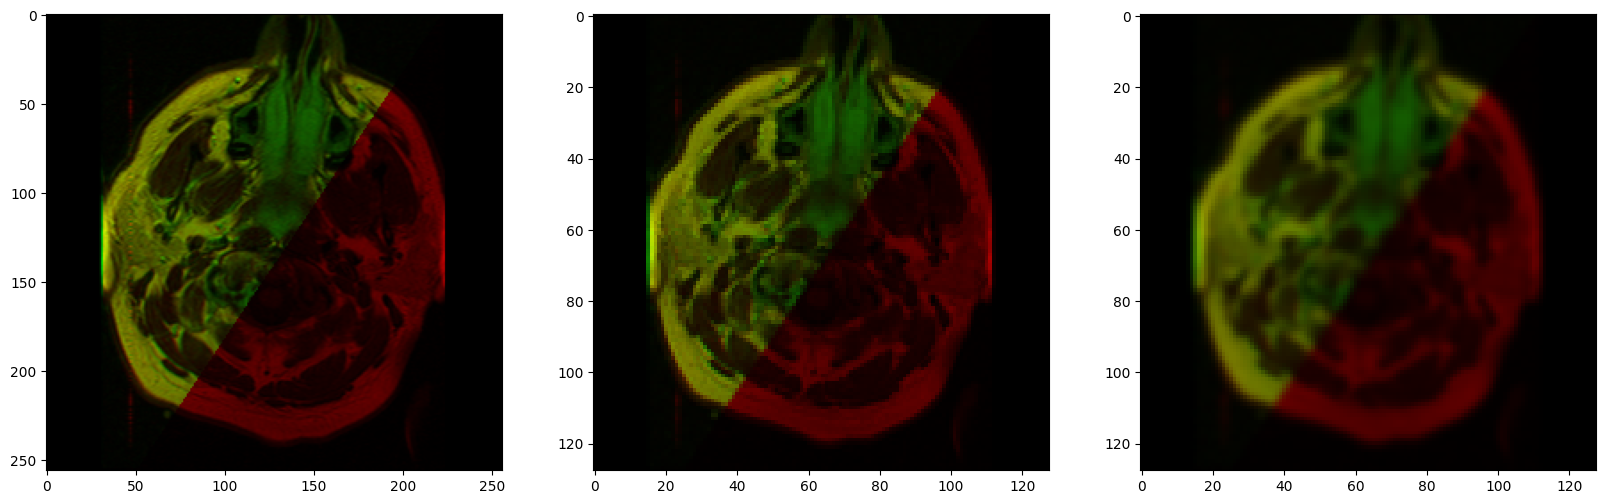

In [53]:
original_img = Image.open("./../mri_dataset/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif")
ds = downsample_image(original_img, target_resolution)
ds_blur = downsample_image_blur(original_img, target_resolution)
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.imshow(original_img)
plt.subplot(1,3,2)
plt.imshow(ds)
plt.subplot(1,3,3)
plt.imshow(ds_blur)

In [54]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
print(y_train.shape)
print(X_train.shape)

(3143, 256, 256, 3)
(3143, 128, 128, 3)


In [56]:
upsamples_per_scale = {
    2: 1,
    4: 2,
    8: 3
}

In [57]:
def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)
    
def upsample(x_in, num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = Lambda(pixel_shuffle(scale=2))(x)
    return PReLU(shared_axes=[1, 2])(x)


def residual_block(block_input, num_filters, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(block_input)
    x = BatchNormalization(momentum=momentum)(x)
    x = PReLU(shared_axes=[1, 2])(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization(momentum=momentum)(x)
    x = Add()([block_input, x])
    return x


def build_srresnet(scale=2, num_filters=64, num_res_blocks=16):
    if scale not in upsamples_per_scale:
        raise ValueError(f"available scales are: {upsamples_per_scale.keys()}")

    num_upsamples = upsamples_per_scale[scale]

    lr = Input(shape=(None, None, 3))
    x = lr

    x = Conv2D(num_filters, kernel_size=9, padding='same')(x)
    x = x_1 = PReLU(shared_axes=[1, 2])(x)

    for _ in range(num_res_blocks):
        x = residual_block(x, num_filters)

    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x_1, x])

    for _ in range(num_upsamples):
        x = upsample(x, num_filters * 4)

    x = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    sr = x#Lambda(denormalize_m11)(x)

    return Model(lr, sr)

In [60]:
input_shape

(128, 128, 3)

In [61]:
input_shape = target_resolution + (3,)  # (256, 256, 3)
#super_resolution_model = build_super_resolution_model(input_shape) #build_generator(input_shape) #
super_resolution_model = build_srresnet(num_res_blocks=16, scale = 2)

In [62]:
from tensorflow.keras.callbacks import ModelCheckpoint

def train_model(model, loss, batch_size, epochs, checkpoint_path):
    learning_rate = 0.001
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss=loss)
    
    # Define ModelCheckpoint callback to save model weights after each epoch
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path+"weights_epoch_{epoch:02d}.h",
                                          save_weights_only=False,
                                          save_best_only=False, verbose = 2)
    
    # Train the model with the ModelCheckpoint callback
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[checkpoint_callback])
    
    return history

# Specify the path where model weights will be saved
checkpoint_path = "./SRResNet/"

# Train the model and save weights after each epoch
history = train_model(model=super_resolution_model,
                      loss=MeanSquaredError(),
                      batch_size=32,
                      epochs=10,
                      checkpoint_path=checkpoint_path)


Epoch 1/10
99/99 [==============================] - ETA: 0s - loss: 0.0297
Epoch 1: saving model to ./SRResNet/weights_epoch_01.h
INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_01.h/assets


INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_01.h/assets


99/99 [==============================] - 89s 748ms/step - loss: 0.0297 - val_loss: 0.0268
Epoch 2/10
99/99 [==============================] - ETA: 0s - loss: 0.0050
Epoch 2: saving model to ./SRResNet/weights_epoch_02.h
INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_02.h/assets


INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_02.h/assets


99/99 [==============================] - 72s 730ms/step - loss: 0.0050 - val_loss: 0.0098
Epoch 3/10
99/99 [==============================] - ETA: 0s - loss: 0.0017
Epoch 3: saving model to ./SRResNet/weights_epoch_03.h
INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_03.h/assets


INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_03.h/assets


99/99 [==============================] - 71s 714ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 4/10
99/99 [==============================] - ETA: 0s - loss: 0.0014
Epoch 4: saving model to ./SRResNet/weights_epoch_04.h
INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_04.h/assets


INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_04.h/assets


99/99 [==============================] - 72s 733ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 5/10
99/99 [==============================] - ETA: 0s - loss: 0.0012
Epoch 5: saving model to ./SRResNet/weights_epoch_05.h
INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_05.h/assets


INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_05.h/assets


99/99 [==============================] - 71s 714ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 6/10
99/99 [==============================] - ETA: 0s - loss: 0.0011
Epoch 6: saving model to ./SRResNet/weights_epoch_06.h
INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_06.h/assets


INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_06.h/assets


99/99 [==============================] - 72s 733ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 7/10
99/99 [==============================] - ETA: 0s - loss: 9.9257e-04
Epoch 7: saving model to ./SRResNet/weights_epoch_07.h
INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_07.h/assets


INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_07.h/assets


99/99 [==============================] - 71s 714ms/step - loss: 9.9257e-04 - val_loss: 8.4210e-04
Epoch 8/10
99/99 [==============================] - ETA: 0s - loss: 8.4024e-04
Epoch 8: saving model to ./SRResNet/weights_epoch_08.h
INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_08.h/assets


INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_08.h/assets


99/99 [==============================] - 73s 735ms/step - loss: 8.4024e-04 - val_loss: 0.0016
Epoch 9/10
99/99 [==============================] - ETA: 0s - loss: 7.8413e-04
Epoch 9: saving model to ./SRResNet/weights_epoch_09.h
INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_09.h/assets


INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_09.h/assets


99/99 [==============================] - 71s 715ms/step - loss: 7.8413e-04 - val_loss: 0.0030
Epoch 10/10
99/99 [==============================] - ETA: 0s - loss: 7.3027e-04
Epoch 10: saving model to ./SRResNet/weights_epoch_10.h
INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_10.h/assets


INFO:tensorflow:Assets written to: ./SRResNet/weights_epoch_10.h/assets


99/99 [==============================] - 72s 732ms/step - loss: 7.3027e-04 - val_loss: 0.0012


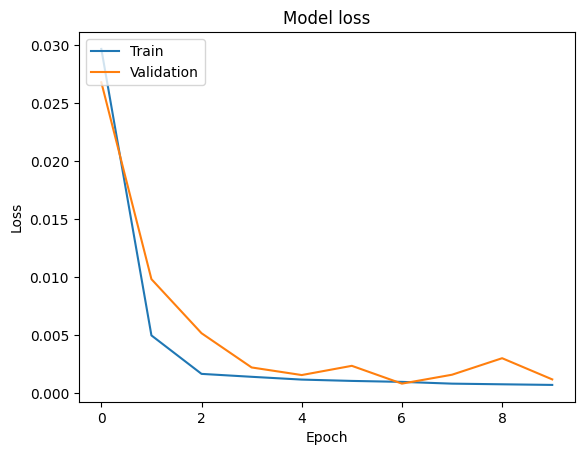

In [63]:
def plot_losses(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig("SRResNet_losses.png", dpi = 300)
    plt.show()

# Call the function to plot losses
plot_losses(history)

In [ ]:
super_resolution_model.save('super_resolution_model.keras')

In [64]:
model_array = []
for model_path in os.listdir("SRResNet"):
    if ".h" in model_path:
        model = load_model("SRResNet/"+model_path)
        model_array.append(model)

1/1 [==============================] - 0s 20ms/step


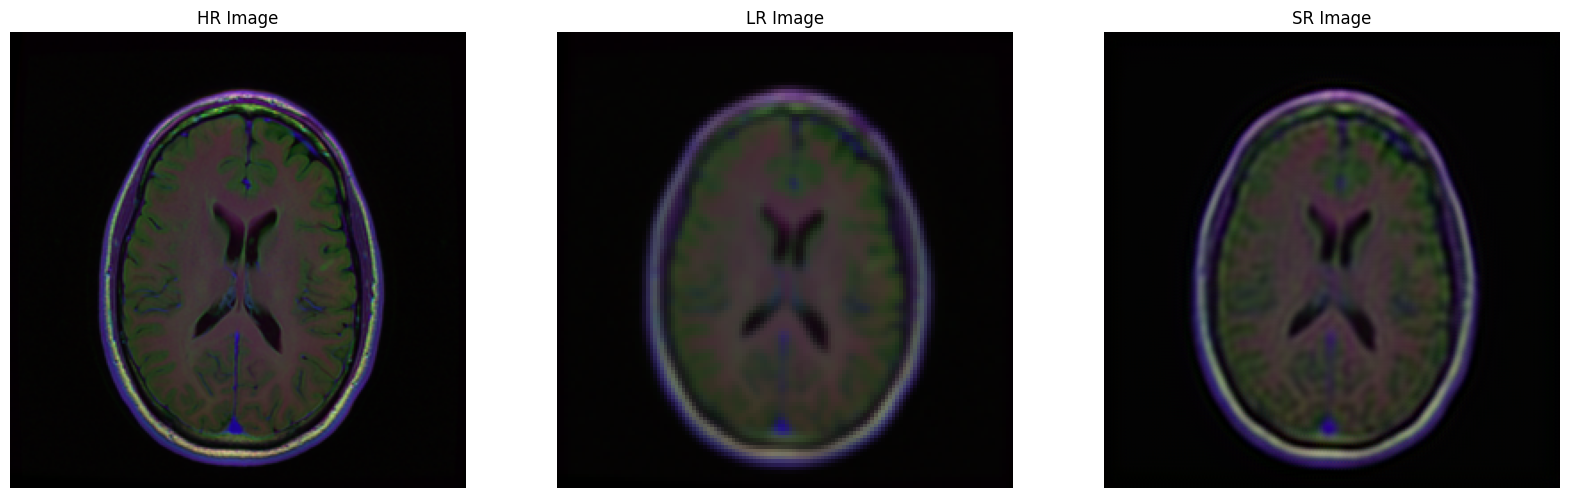

1/1 [==============================] - 0s 20ms/step


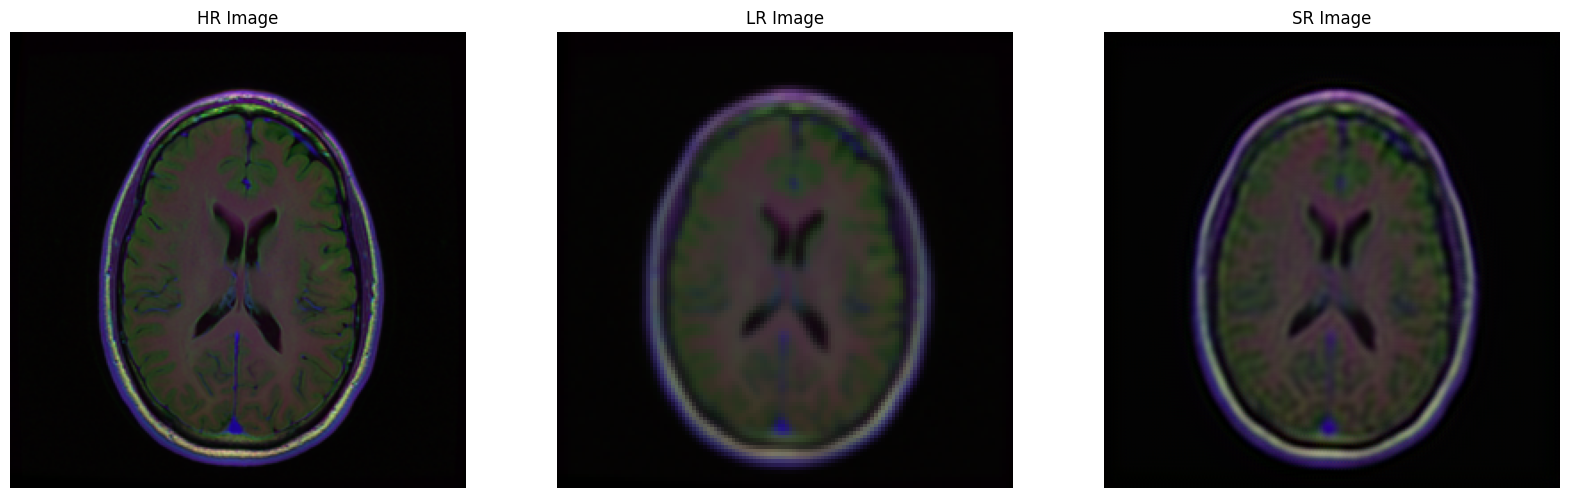

1/1 [==============================] - 0s 20ms/step


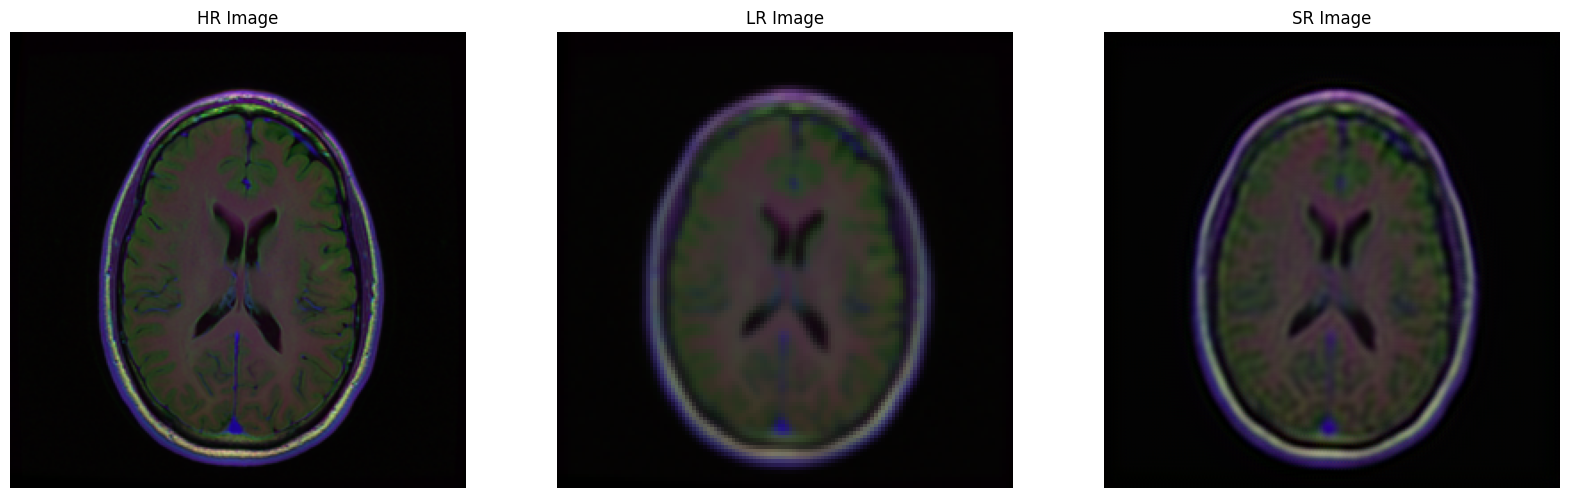

1/1 [==============================] - 0s 20ms/step


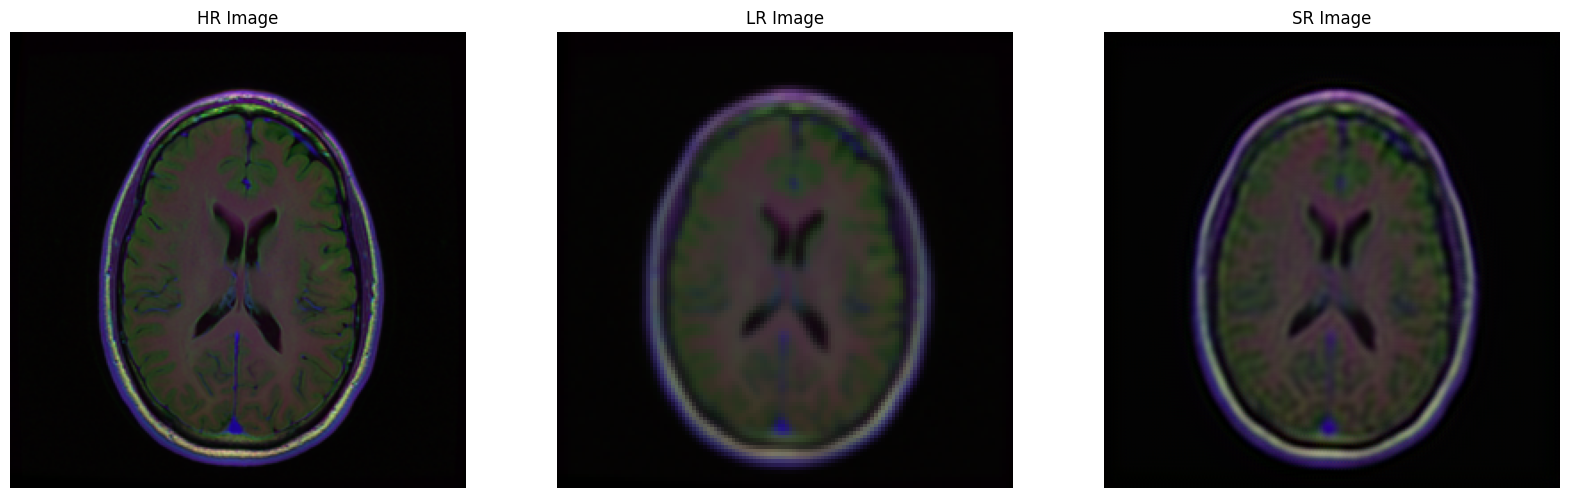

1/1 [==============================] - 0s 20ms/step


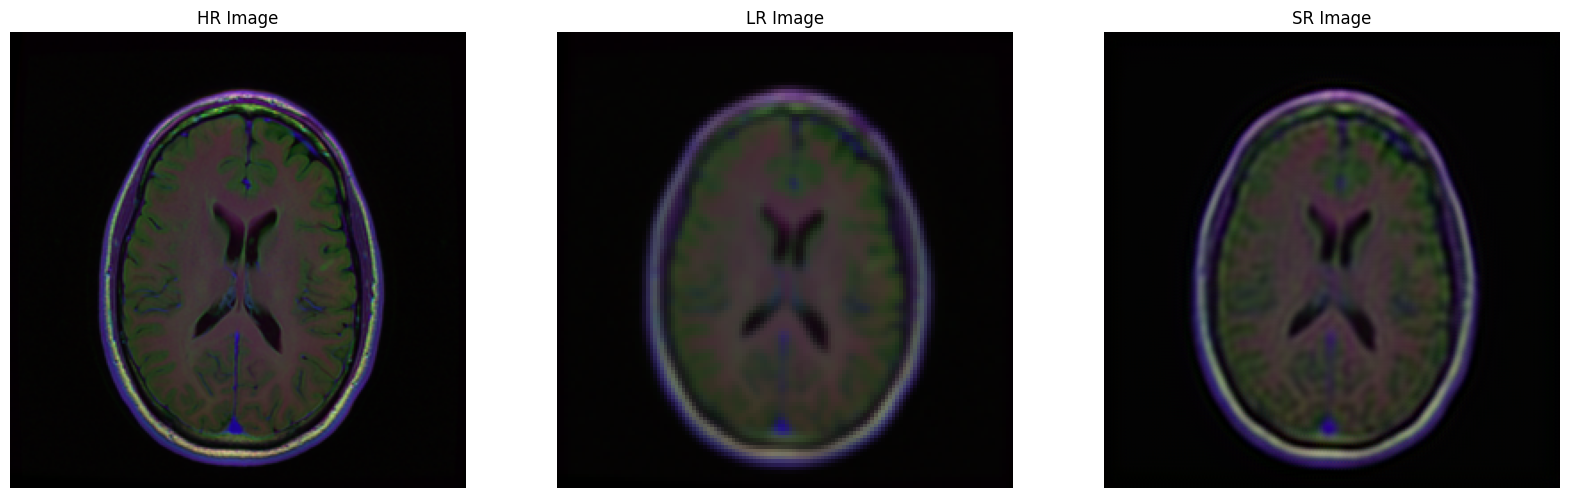

1/1 [==============================] - 0s 20ms/step


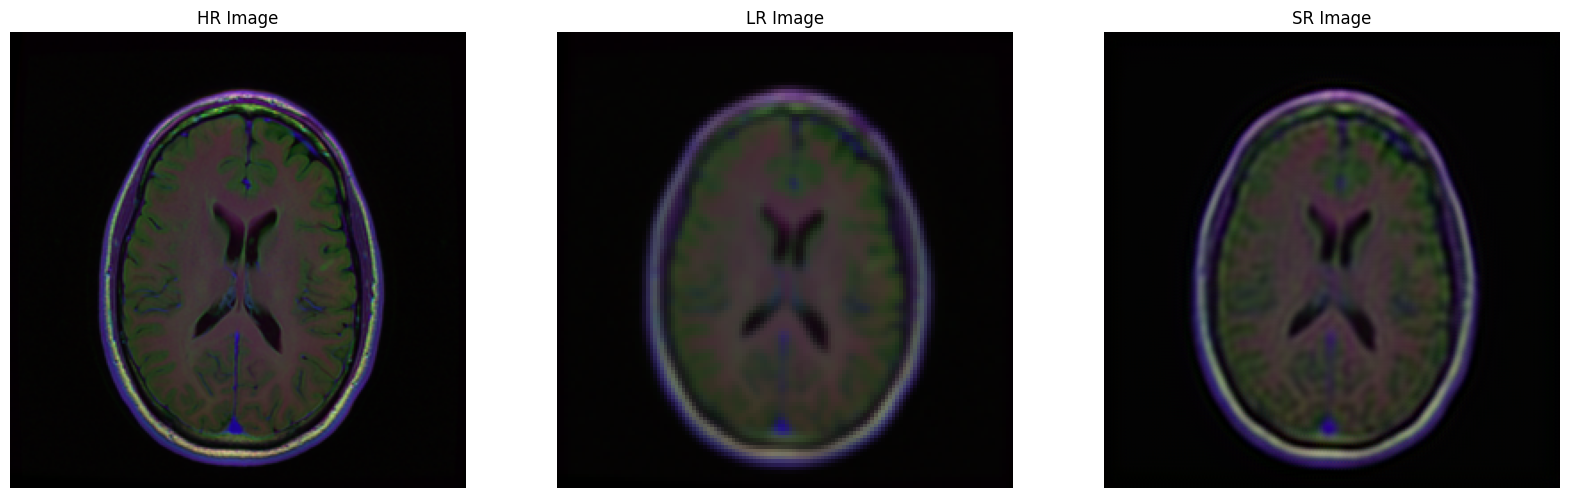

1/1 [==============================] - 0s 20ms/step


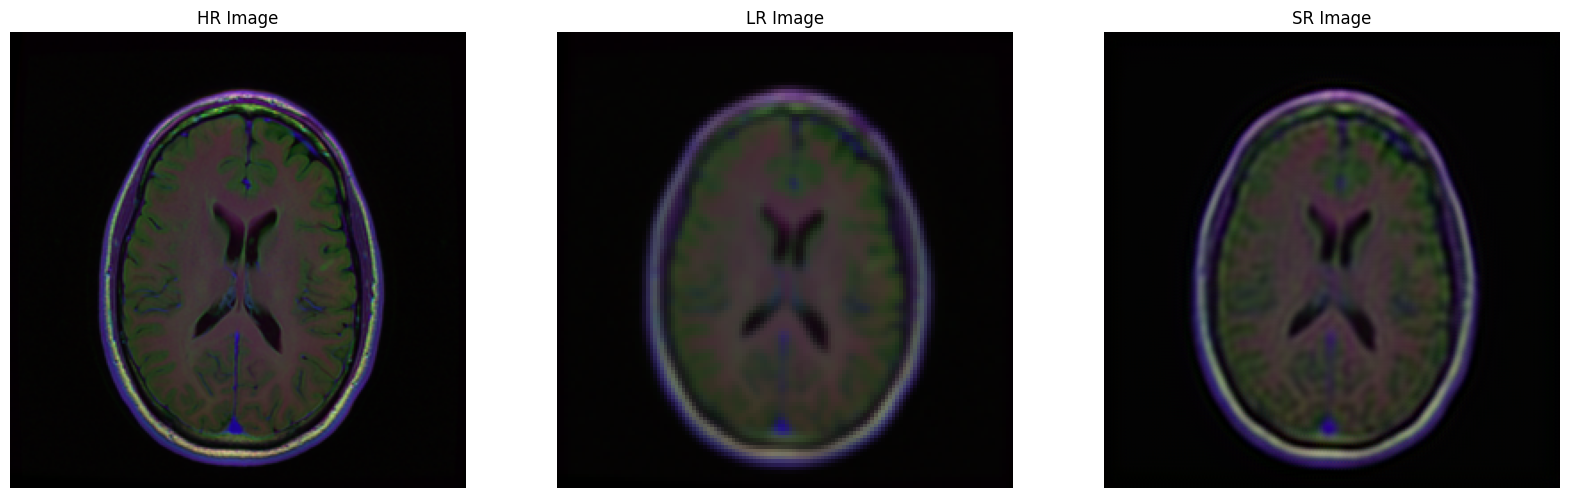

1/1 [==============================] - 0s 21ms/step


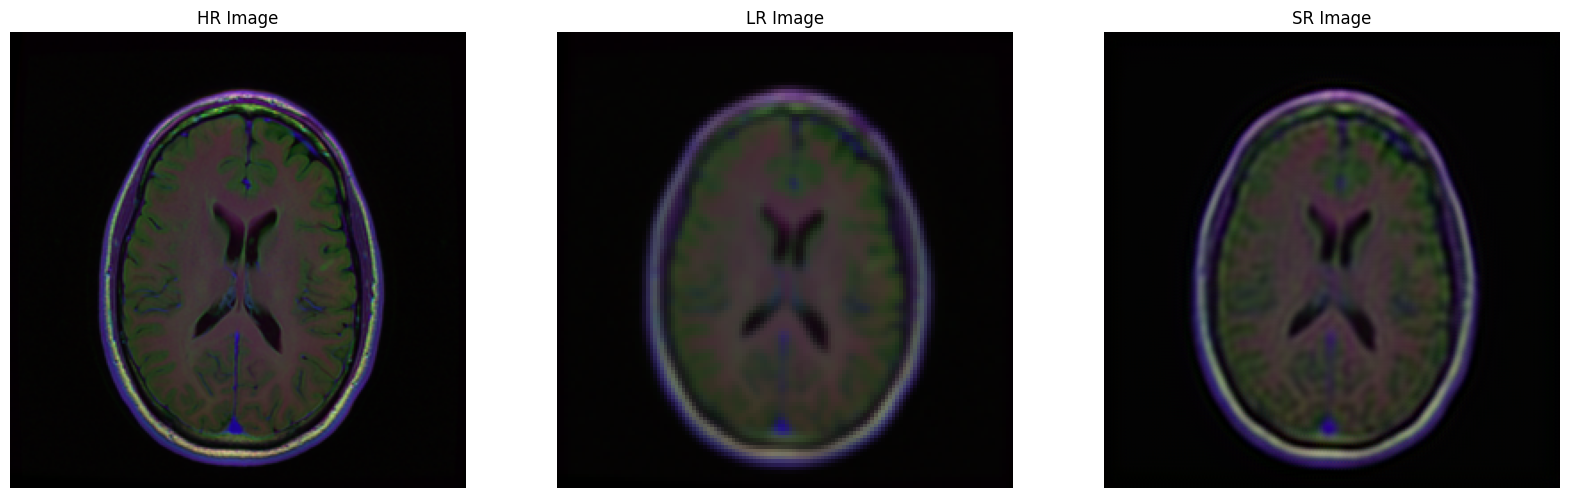

1/1 [==============================] - 0s 21ms/step


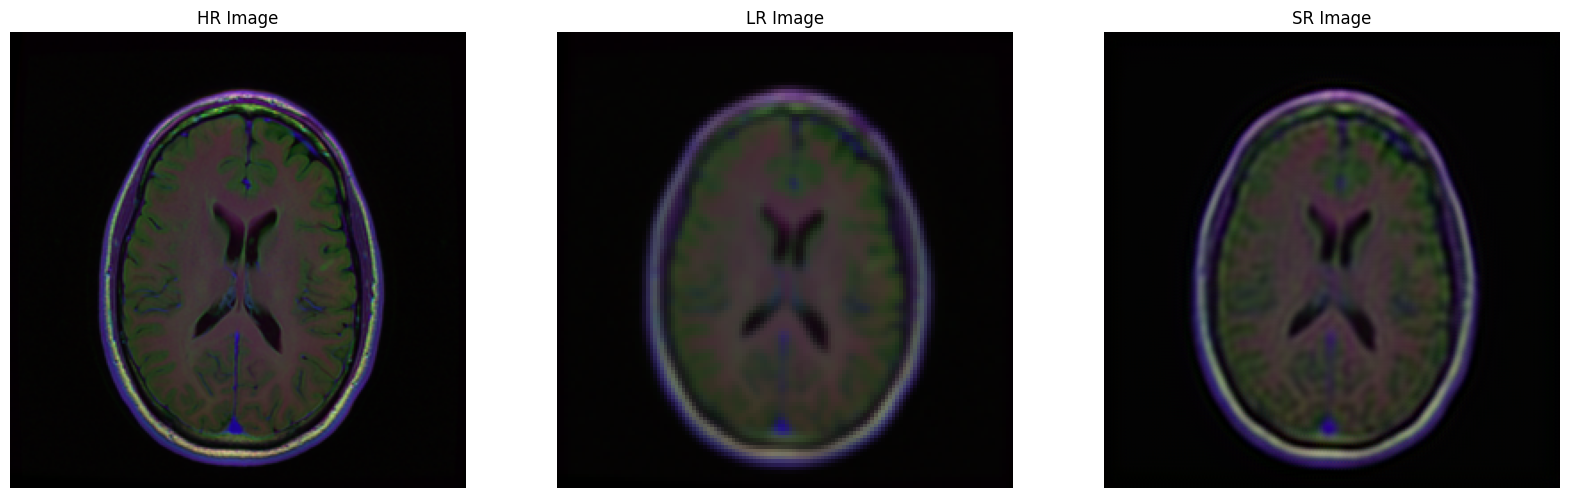

1/1 [==============================] - 0s 20ms/step


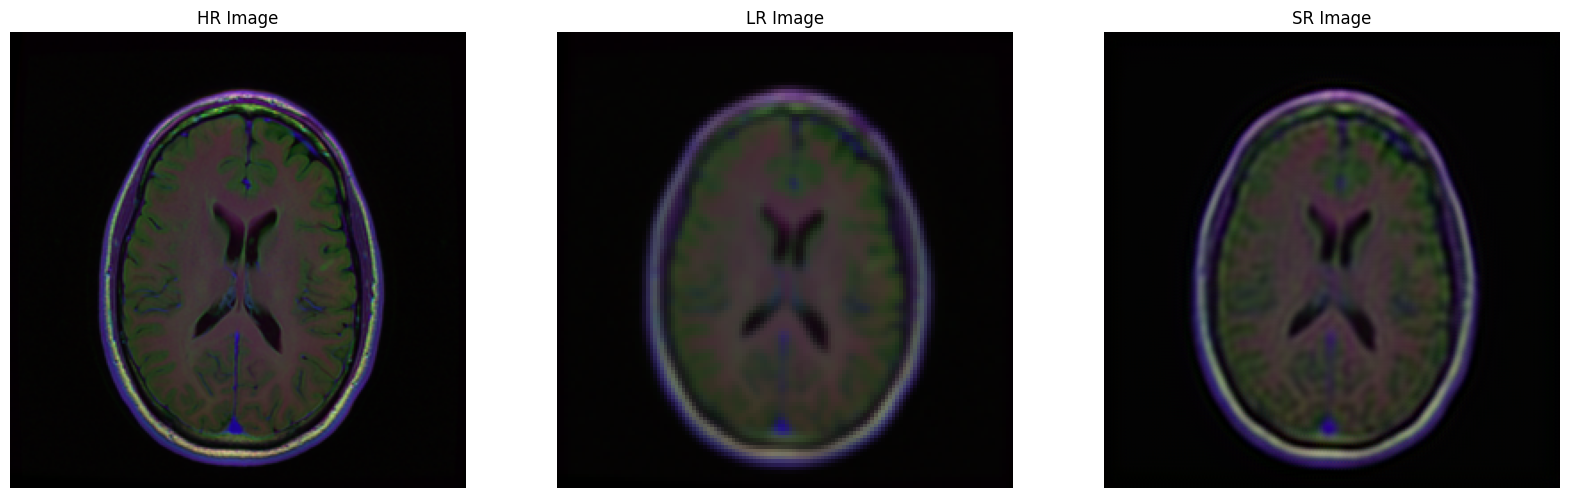

In [69]:
image_number = np.random.randint(len(X_val))
X_sample = X_val[image_number][np.newaxis, ...]
y_sample = y_val[image_number]
for idx, model in enumerate(model_array):
    predicted = super_resolution_model.predict(X_sample)
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(y_sample)
    plt.title('HR Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(X_sample[0])
    plt.title('LR Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted[0])
    plt.title('SR Image')
    plt.axis('off')

    plt.savefig(f"./SRResNet_images/Results_model_epoch_{idx}.png", dpi=300)
    plt.show()



